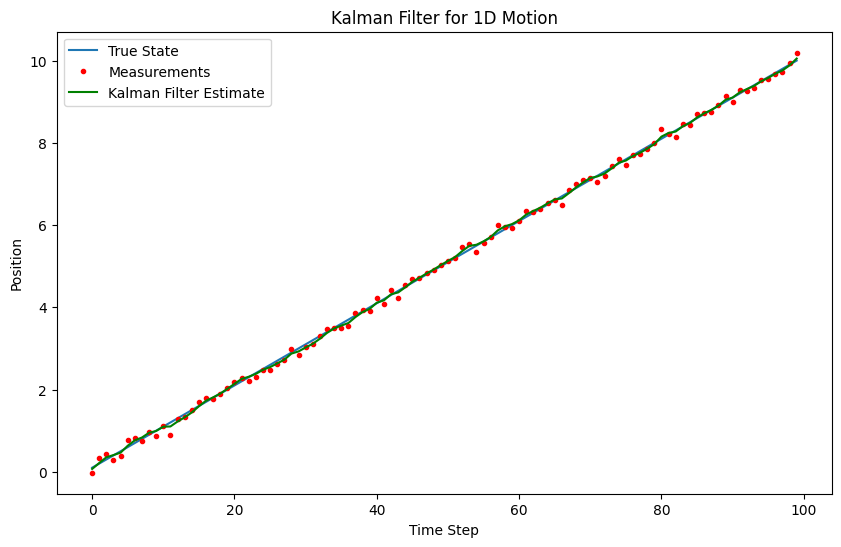

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, F, H, Q, R, P, x0):
        self.F = F  # матрица перехода состояния
        self.H = H  # матрица наблюдения
        self.Q = Q  # ковариация шума процесса
        self.R = R  # ковариация шума измерения
        self.P = P  # начальная ковариация ошибки
        self.x = x0 # начальное состояние

    def predict(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.H.shape[1])
        self.P = np.dot((I - np.dot(K, self.H)), self.P)
        return self.x

# Параметры модели
dt = 0.1
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0]])
Q = np.array([[0.05, 0.05], [0.05, 0.05]])
R = np.array([[0.5]])
P = np.array([[0.1, 0.1], [0.1, 0.1]])
x0 = np.array([[0], [1]])

# Создаем фильтр Калмана
kf = KalmanFilter(F, H, Q, R, P, x0)

# Генерируем зашумленные измерения
true_states = []
measurements = []
estimated_states = []

for _ in range(100):
    true_state = np.dot(F, x0)
    measurement = np.dot(H, true_state) + np.random.normal(0, 0.1)

    kf.predict()
    estimated_state = kf.update(measurement)

    true_states.append(true_state[0, 0])
    measurements.append(measurement[0, 0])
    estimated_states.append(estimated_state[0, 0])

    x0 = true_state

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(true_states, label='True State')
plt.plot(measurements, 'r.', label='Measurements')
plt.plot(estimated_states, 'g-', label='Kalman Filter Estimate')
plt.legend()
plt.title('Kalman Filter for 1D Motion')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.show()

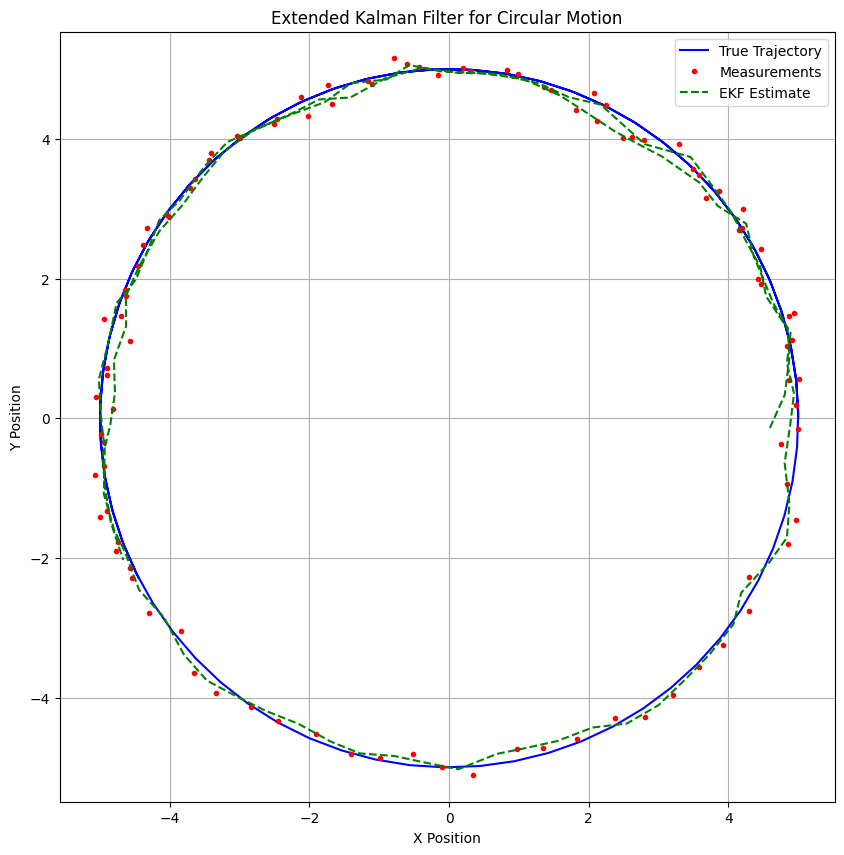

MSE of raw measurements: 0.0109
MSE of EKF estimates: 0.0443


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, f, h, Q, R, P, x0):
        self.f = f  # нелинейная функция перехода состояния
        self.h = h  # нелинейная функция измерения
        self.Q = Q  # ковариация шума процесса
        self.R = R  # ковариация шума измерения
        self.P = P  # начальная ковариация ошибки
        self.x = x0 # начальное состояние

    def predict(self, u=0):
        self.x = self.f(self.x, u)
        F = self.jacobian_f(self.x, u)
        self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
        return self.x

    def update(self, z):
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(len(self.x))
        self.P = np.dot((I - np.dot(K, H)), self.P)
        return self.x

    def jacobian_f(self, x, u):
        # Вычисление якобиана функции f
        return np.array([[1, 0, -u*np.sin(x[2]), u*np.cos(x[2])],
                         [0, 1, u*np.cos(x[2]), u*np.sin(x[2])],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])

    def jacobian_h(self, x):
        # Вычисление якобиана функции h
        return np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0]])

# Определение нелинейных функций модели
def f(x, u):
    # x = [x, y, theta, v]
    return np.array([x[0] + u*np.cos(x[2]),
                     x[1] + u*np.sin(x[2]),
                     x[2] + u/0.1,
                     x[3]])

def h(x):
    return np.array([x[0], x[1]])

# Параметры модели
Q = np.eye(4) * 0.1
R = np.eye(2) * 0.1
P = np.eye(4)
x0 = np.array([0, 0, 0, 1])

# Создаем EKF
ekf = ExtendedKalmanFilter(f, h, Q, R, P, x0)

# Генерируем данные и применяем фильтр
true_states = []
measurements = []
estimated_states = []

time_steps = 100
dt = 0.1
radius = 5

for t in range(time_steps):
    # Истинное состояние (движение по кругу)
    theta = t * dt
    true_state = np.array([radius * np.cos(theta),
                           radius * np.sin(theta),
                           theta + np.pi/2,
                           radius * dt])

    # Генерируем зашумленное измерение
    measurement = h(true_state) + np.random.normal(0, 0.1, 2)

    # Применяем EKF
    ekf.predict(u=dt)
    estimated_state = ekf.update(measurement)

    true_states.append(true_state[:2])
    measurements.append(measurement)
    estimated_states.append(estimated_state[:2])

# Преобразуем списки в массивы numpy для удобства
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Визуализация результатов
plt.figure(figsize=(10, 10))
plt.plot(true_states[:, 0], true_states[:, 1], 'b-', label='True Trajectory')
plt.plot(measurements[:, 0], measurements[:, 1], 'r.', label='Measurements')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], 'g--', label='EKF Estimate')
plt.legend()
plt.title('Extended Kalman Filter for Circular Motion')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Анализ ошибки
mse_measurements = np.mean((measurements - true_states[:, :2])**2)
mse_ekf = np.mean((estimated_states - true_states[:, :2])**2)

print(f"MSE of raw measurements: {mse_measurements:.4f}")
print(f"MSE of EKF estimates: {mse_ekf:.4f}")

In [ ]:
# Генерируем зашумленные измерения
true_states = []
measurements = []
estimated_states_kf = []
estimated_states_ekf = []

for _ in range(100):
    true_state = np.dot(F, x0)
    measurement = np.dot(H, true_state) + np.random.normal(0, 0.1)

    kf.predict()
    estimated_state_kf = kf.update(measurement)
    ekf.predict()
    estimated_state_ekf = ekf.update(measurement)

    true_states.append(true_state[0, 0])
    measurements.append(measurement[0, 0])
    estimated_states_kf.append(estimated_state_kf[0, 0])
    estimated_states_ekf.append(estimated_state_ekf[0, 0])

    x0 = true_state

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(true_states, label='True State')
plt.plot(measurements, 'r.', label='Measurements')
plt.plot(estimated_states_kf, 'g-', label='Kalman Filter Estimate')
plt.plot(estimated_states_ekf, 'b-', label='EKF Filter Estimate')
plt.legend()
plt.title('Kalman Filter for 1D Motion')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.show()

ValueError: shapes (2,2) and (4,) not aligned: 2 (dim 1) != 4 (dim 0)

# Далее код ГПТ

In [ ]:
def f(x, u):
    # x = [x, y, vx, vy]
    dt = u  # время шага
    r = np.sqrt(x[0]**2 + x[1]**2)  # радиус
    theta = np.arctan2(x[1], x[0])  # угол
    omega = 0.3  # угловая скорость
    new_theta = theta + omega * dt
    new_x = r * np.cos(new_theta)
    new_y = r * np.sin(new_theta)
    return np.array([new_x, new_y, -omega * new_y, omega * new_x])

def h(x):
    # Измеряются только позиции x и y
    return np.array([x[0], x[1]])

In [ ]:
def generate_linear_data(steps=100, dt=0.1):
    true_states = []
    measurements = []
    x = np.array([0.0, 1.0])  # положение и скорость
    F = np.array([[1, dt], [0, 1]])
    H = np.array([[1, 0]])
    for _ in range(steps):
        x = F @ x
        z = H @ x + np.random.normal(0, 0.5)
        true_states.append(x[0])
        measurements.append(z)
    return true_states, measurements

In [ ]:
def generate_circular_data(steps=100, dt=0.1):
    true_states = []
    measurements = []
    x = np.array([10.0, 0.0, 0.0, 10.0])  # x, y, vx, vy
    for _ in range(steps):
        x = f(x, dt)
        z = h(x) + np.random.normal(0, 0.5, size=2)
        true_states.append(x[:2])
        measurements.append(z)
    return np.array(true_states), np.array(measurements)

In [ ]:
# Параметры
dt_kf = 0.1
F_kf = np.array([[1, dt_kf], [0, 1]])
H_kf = np.array([[1, 0]])
Q_kf = np.eye(2) * 0.01
R_kf = np.eye(1) * 0.5
P_kf = np.eye(2) * 0.1
x0_kf = np.array([[0.0], [1.0]])

kf = KalmanFilter(F_kf, H_kf, Q_kf, R_kf, P_kf, x0_kf)

In [ ]:
# Параметры
Q_ekf = np.eye(4) * 0.01
R_ekf = np.eye(2) * 0.5
P_ekf = np.eye(4) * 0.1
x0_ekf = np.array([1.0, 0.0, 0.0, 1.0])

ekf = ExtendedKalmanFilter(f, h, Q_ekf, R_ekf, P_ekf, x0_ekf)

In [ ]:
def run_filter(kf, ekf, true_states, measurements, linear=True):
    kf_estimates = []
    ekf_estimates = []

    if linear:
        kf.x = np.array([[0.0], [1.0]])
        for z in measurements:
            kf.predict()
            kf.update(np.array([z]).reshape(-1, 1))  # гарантированно (m, 1)
            kf_estimates.append(kf.x[0, 0])
    else:
        ekf.x = np.array([1.0, 0.0, 0.0, 1.0])
        for z in measurements:
            ekf.predict(u=0.1)
            ekf.update(z)
            ekf_estimates.append(ekf.x[:2].copy())

    return kf_estimates, ekf_estimates

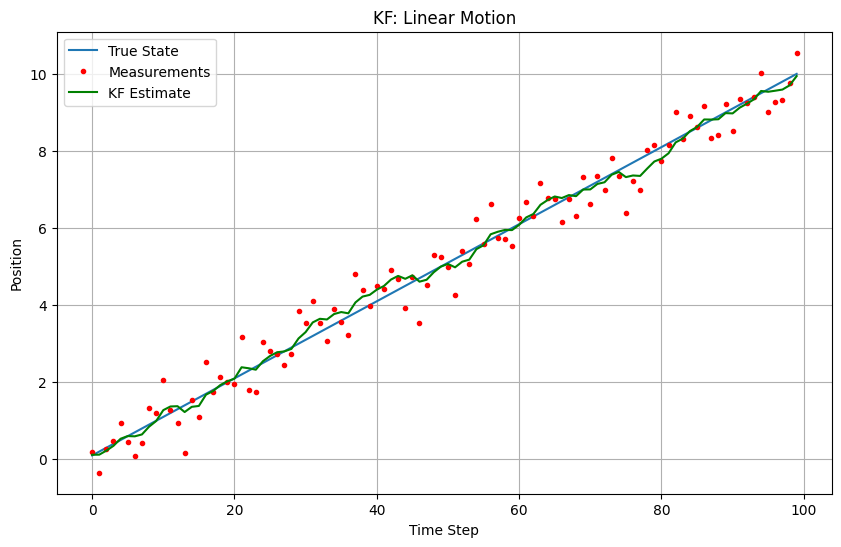

In [ ]:
true_states_l, measurements_l = generate_linear_data()

# Используем KF
kf = KalmanFilter(F_kf, H_kf, Q_kf, R_kf, P_kf, x0_kf)
kf_estimates_l, _ = run_filter(kf, None, true_states_l, measurements_l, linear=True)

plt.figure(figsize=(10, 6))
plt.plot(true_states_l, label='True State')
plt.plot(measurements_l, 'r.', label='Measurements')
plt.plot(kf_estimates_l, 'g-', label='KF Estimate')
plt.title('KF: Linear Motion')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.grid(True)
plt.show()

# Новый

# И ещё разок по новой

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для генерации данных
def generate_circular_data(radius=5, steps=360, dt=0.1):
    true_states = []
    measurements = []
    x = np.array([radius, 0.0, 0.0, radius])  # x, y, vx, vy
    for _ in range(steps):
        x = f(x, dt)
        z = h(x) + np.random.normal(0, 0.1, size=2)
        true_states.append(x[:2])
        measurements.append(z)
    return np.array(true_states), np.array(measurements)

# Функции перехода и наблюдения
def f(x, dt):
    omega = 0.3  # угловая скорость
    r = np.sqrt(x[0]**2 + x[1]**2)
    theta = np.arctan2(x[1], x[0])
    new_theta = theta + omega * dt
    new_x = r * np.cos(new_theta)
    new_y = r * np.sin(new_theta)
    return np.array([new_x, new_y, -omega * new_y, omega * new_x])

def h(x):
    return np.array([x[0], x[1]])

In [ ]:
class KalmanFilter:
    def __init__(self, F, H, Q, R, P, x0):
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
        self.P = P
        self.x = x0

    def predict(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.H.shape[1])
        self.P = np.dot((I - np.dot(K, self.H)), self.P)
        return self.x

class ExtendedKalmanFilter:
    def __init__(self, f, h, Q, R, P, x0):
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.P = P
        self.x = x0

    def predict(self, u=0):
        self.x = self.f(self.x, u)
        F = self.jacobian_f(self.x, u)
        self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
        return self.x

    def update(self, z):
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(len(self.x))
        self.P = np.dot((I - np.dot(K, H)), self.P)
        return self.x

    def jacobian_f(self, x, u):
        omega = 0.3
        dt = u
        theta = np.arctan2(x[1], x[0])
        return np.array([
            [1, 0, -dt * np.sin(theta), dt * np.cos(theta)],
            [0, 1, dt * np.cos(theta), dt * np.sin(theta)],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

    def jacobian_h(self, x):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

In [ ]:
# Параметры для EKF
Q_ekf = np.eye(4) * 0.1
R_ekf = np.eye(2) * 0.5
P_ekf = np.eye(4) * 1.0
x0_ekf = np.array([5.0, 0.0, 0.0, 5.0])  # Радиус = 5

# Параметры для KF
F_kf_2d = np.array([
    [1, 0, 0.1, 0],
    [0, 1, 0, 0.1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
H_kf_2d = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
Q_kf_2d = np.eye(4) * 0.01
R_kf_2d = np.eye(2) * 0.5
P_kf_2d = np.eye(4) * 0.1
x0_kf_2d = np.array([5.0, 0.0, 0.0, 5.0]).reshape(-1, 1)  # Радиус = 5

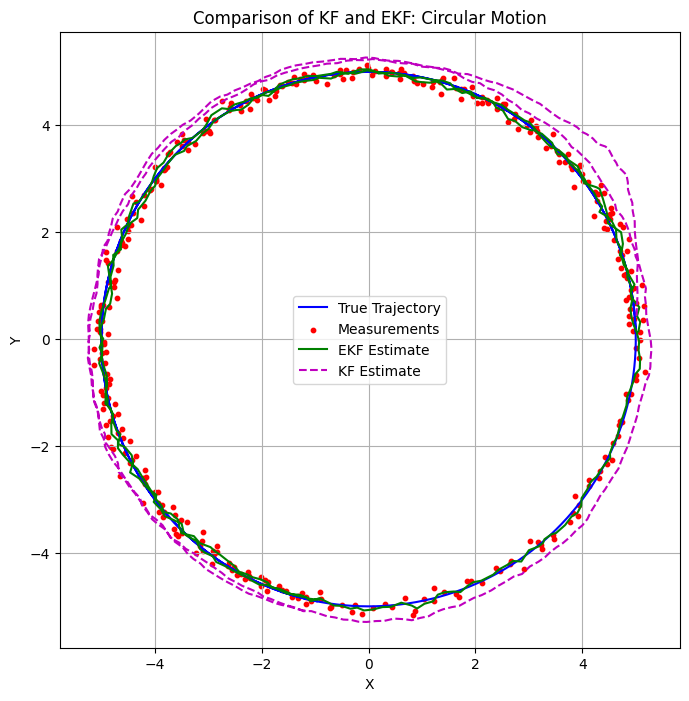

In [ ]:
# Создание фильтров
ekf = ExtendedKalmanFilter(f, h, Q_ekf, R_ekf, P_ekf, x0_ekf)
kf = KalmanFilter(F_kf_2d, H_kf_2d, Q_kf_2d, R_kf_2d, P_kf_2d, x0_kf_2d)

# Генерация данных
true_states_c, measurements_c = generate_circular_data(radius=5, steps=360, dt=0.1)

# Списки для хранения оценок
ekf_estimates_c = []
kf_estimates_c = []

# Прогон через EKF
for z in measurements_c:
    ekf.predict(u=0.1)
    ekf.update(z)
    ekf_estimates_c.append(ekf.x[:2].copy())

# Прогон через KF
for z in measurements_c:
    kf.predict()
    kf.update(np.array([z]).reshape(-1, 1))
    kf_estimates_c.append(kf.x[:2].copy())

# Преобразование списков в массивы NumPy
ekf_estimates_c = np.array(ekf_estimates_c)
kf_estimates_c = np.array(kf_estimates_c)

# Визуализация
plt.figure(figsize=(8, 8))
plt.plot(true_states_c[:, 0], true_states_c[:, 1], label='True Trajectory', color='blue')
plt.scatter(measurements_c[:, 0], measurements_c[:, 1], c='r', s=10, label='Measurements')
plt.plot(ekf_estimates_c[:, 0], ekf_estimates_c[:, 1], 'g-', label='EKF Estimate')
plt.plot(kf_estimates_c[:, 0], kf_estimates_c[:, 1], 'm--', label='KF Estimate')  # Magenta dashed line
plt.title('Comparison of KF and EKF: Circular Motion')
plt.legend()
plt.axis('equal')
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
import requests

# Отправляем GET-запрос
response = requests.get("http://api.open-notify.org/iss-now.json")

# Преобразуем ответ в JSON
obj = response.json()

# Выводим нужные данные
print(obj['timestamp'])
print(obj['iss_position']['latitude'], obj['iss_position']['longitude'])

1749571575
-51.5106 103.4984


In [ ]:
import requests
import time

# Настройки
URL = "http://api.open-notify.org/iss-now.json"
INTERVAL = 10  # Интервал между запросами в секундах
DURATION = 1 * 60  # Общее время сбора данных в секундах (15 минут)

# Список для хранения собранных данных
data_log = []

# Засекаем время начала работы
start_time = time.time()

print("Начинаем сбор данных...")

while (time.time() - start_time) < DURATION:
    try:
        # Отправляем GET-запрос
        response = requests.get(URL)
        response.raise_for_status()  # Проверяем на ошибки HTTP

        # Парсим JSON
        obj = response.json()

        # Сохраняем timestamp и координаты
        log_entry = {
            'timestamp': obj['timestamp'],
            'latitude': obj['iss_position']['latitude'],
            'longitude': obj['iss_position']['longitude']
        }

        data_log.append(log_entry)

        print(f"Записано: {log_entry}")

        # Ждём заданный интервал
        time.sleep(INTERVAL)

    except requests.exceptions.RequestException as e:
        print(f"Ошибка при выполнении запроса: {e}")
        time.sleep(INTERVAL)  # Можно попробовать снова через 10 секунд

# Выводим общее количество собранных записей
print(f"\nСбор данных завершён. Всего записей: {len(data_log)}")

Начинаем сбор данных...
Записано: {'timestamp': 1749571666, 'latitude': '-51.5336', 'longitude': '112.6200'}
Записано: {'timestamp': 1749571692, 'latitude': '-51.4002', 'longitude': '115.1982'}
Записано: {'timestamp': 1749571704, 'latitude': '-51.3253', 'longitude': '116.2836'}
Записано: {'timestamp': 1749571721, 'latitude': '-51.1881', 'longitude': '117.9532'}

Сбор данных завершён. Всего записей: 4


In [ ]:
data_log

[{'timestamp': 1749571666, 'latitude': '-51.5336', 'longitude': '112.6200'},
 {'timestamp': 1749571692, 'latitude': '-51.4002', 'longitude': '115.1982'},
 {'timestamp': 1749571704, 'latitude': '-51.3253', 'longitude': '116.2836'},
 {'timestamp': 1749571721, 'latitude': '-51.1881', 'longitude': '117.9532'}]

In [ ]:
import requests
import time
import csv

# Настройки
URL = "http://api.open-notify.org/iss-now.json"
INTERVAL = 10  # Интервал между запросами в секундах
DURATION = 90 * 60  # Общее время сбора данных в секундах (90 минут)
CSV_FILENAME = "iss_data_log.csv"

print("Начинаем сбор данных...")

# Открываем файл для записи
with open(CSV_FILENAME, mode='w', newline='') as csvfile:
    fieldnames = ['timestamp', 'latitude', 'longitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Записываем заголовок CSV
    writer.writeheader()

    start_time = time.time()

    while (time.time() - start_time) < DURATION:
        try:
            # Отправляем GET-запрос
            response = requests.get(URL)
            response.raise_for_status()  # Проверяем на ошибки HTTP

            # Парсим JSON
            obj = response.json()

            # Формируем запись
            log_entry = {
                'timestamp': obj['timestamp'],
                'latitude': obj['iss_position']['latitude'],
                'longitude': obj['iss_position']['longitude']
            }

            # Записываем в CSV
            writer.writerow(log_entry)

            print(f"Записано: {log_entry}")

            # Ждём заданный интервал
            time.sleep(INTERVAL)

        except requests.exceptions.RequestException as e:
            print(f"Ошибка при выполнении запроса: {e}")
            time.sleep(INTERVAL)

print(f"\nСбор данных завершён. Данные сохранены в файл: {CSV_FILENAME}")

Начинаем сбор данных...
Записано: {'timestamp': 1749571823, 'latitude': '-49.8300', 'longitude': '127.7215'}
Записано: {'timestamp': 1749571840, 'latitude': '-49.5206', 'longitude': '129.2783'}
Записано: {'timestamp': 1749571853, 'latitude': '-49.2688', 'longitude': '130.4546'}
Записано: {'timestamp': 1749571863, 'latitude': '-49.0663', 'longitude': '131.3507'}
Записано: {'timestamp': 1749571880, 'latitude': '-48.7047', 'longitude': '132.8563'}

Сбор данных завершён. Данные сохранены в файл: iss_data_log.csv


# Построение по данным с МКС

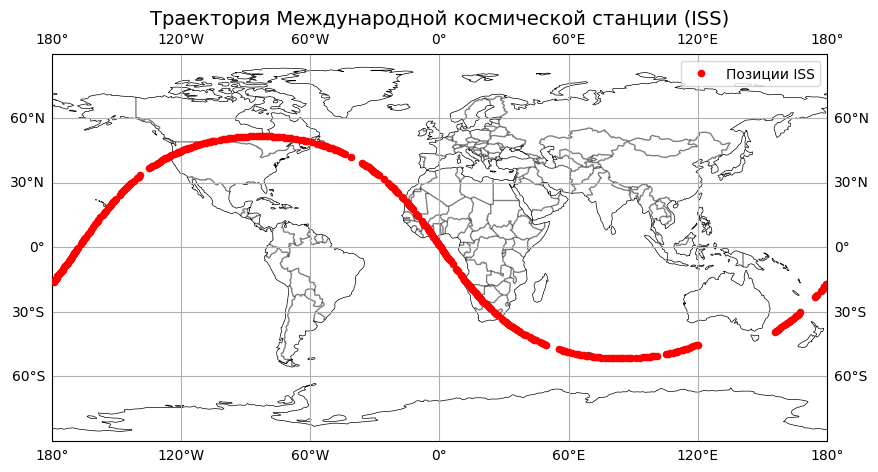

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Имя CSV-файла с данными
CSV_FILENAME = "iss_data_log.csv"

# Загружаем данные из CSV
df = pd.read_csv(CSV_FILENAME)

# Координаты для трека
lats = df['latitude'].values
lons = df['longitude'].values

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем линию маршрута
#ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория ISS')

# Добавляем точки
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Позиции ISS')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()

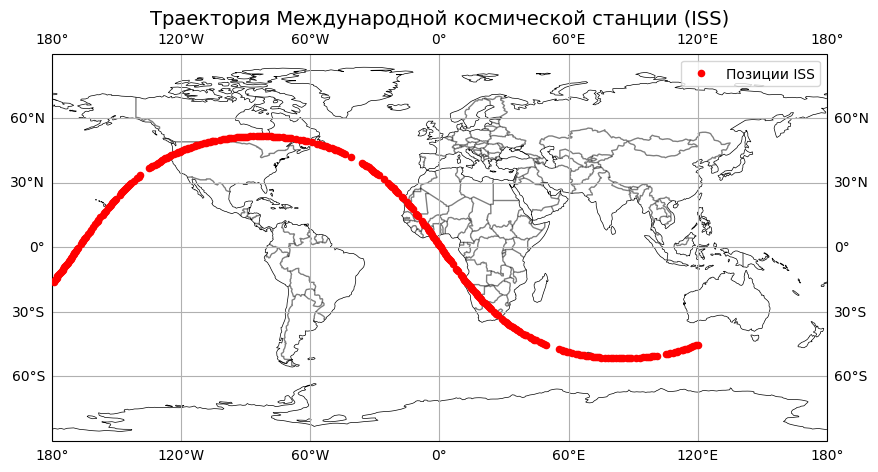

In [ ]:
df1 = df[df['timestamp'] > 1749572700]

# Координаты для трека
lats = df1['latitude'].values
lons = df1['longitude'].values

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем линию маршрута
#ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория ISS')

# Добавляем точки
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Позиции ISS')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()

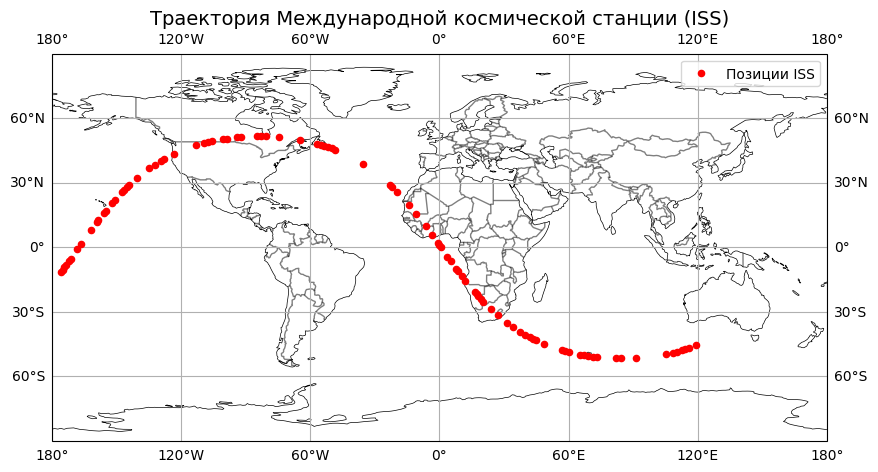

In [ ]:
df1 = df[df['timestamp'] > 1749572700]
df1 = df1[df1['timestamp'] % 4 == 0]

# Координаты для трека
lats = df1['latitude'].values
lons = df1['longitude'].values

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем линию маршрута
#ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория ISS')

# Добавляем точки
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Позиции ISS')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()

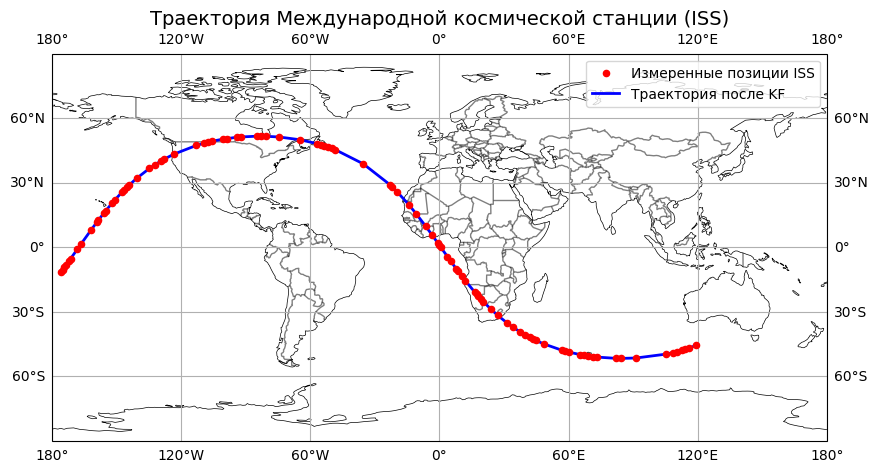

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Загрузка данных
df = pd.read_csv("iss_data_log.csv")

# Фильтрация данных
df1 = df[df['timestamp'] > 1749572700]
df1 = df1[df1['timestamp'] % 4 == 0]

# Координаты для трека
lats = df1['latitude'].values
lons = df1['longitude'].values

# Функция фильтра Калмана
class KalmanFilter:
    def __init__(self, dt, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: Временной шаг между измерениями
        :param std_acc: Стандартное отклонение акселерометра (шум процесса)
        :param x_std_meas: Стандартное отклонение измерений по оси X (широта)
        :param y_std_meas: Стандартное отклонение измерений по оси Y (долгота)
        """
        # Матрица перехода
        self.F = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])

        # Матрица наблюдения
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        # Ковариационная матрица шума процесса
        self.Q = np.eye(4) * std_acc**2

        # Ковариационная матрица шума измерений
        self.R = np.eye(2) * np.diag([x_std_meas**2, y_std_meas**2])

        # Ковариационная матрица ошибки оценки
        self.P = np.eye(4)

        # Состояние системы (начальное значение)
        self.x = np.zeros((4, 1))

    def predict(self):
        """ Предсказать следующее состояние """
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        """ Обновить состояние с новыми измерениями """
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))
        I = np.eye(self.H.shape[1])
        self.P = np.dot(I - np.dot(K, self.H), self.P)

# Параметры фильтра Калмана
dt = 10  # Временной шаг между измерениями (в секундах)
std_acc = 0.5  # Шум процесса (ускорение)
x_std_meas = 0.1  # Шум измерений по широте
y_std_meas = 0.1  # Шум измерений по долготе

# Инициализация фильтра Калмана
kf = KalmanFilter(dt, std_acc, x_std_meas, y_std_meas)

# Списки для хранения фильтрованных данных
filtered_lats = []
filtered_lons = []

# Применение фильтра Калмана к данным
for lat, lon in zip(lats, lons):
    # Измерения
    z = np.array([[lat], [lon]])

    # Предсказание
    kf.predict()

    # Обновление
    kf.update(z)

    # Сохранение фильтрованных данных
    filtered_lats.append(kf.x[0][0])
    filtered_lons.append(kf.x[1][0])

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем исходные данные
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Измеренные позиции ISS')

# Рисуем фильтрованные данные
ax.plot(filtered_lons, filtered_lats, color='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория после KF')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()

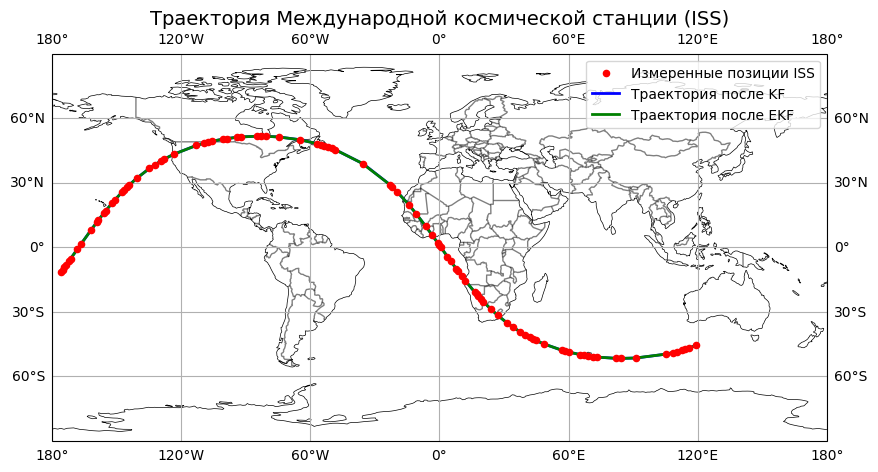

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Загрузка данных
df = pd.read_csv("iss_data_log.csv")

# Фильтрация данных
df1 = df[df['timestamp'] > 1749572700]
df1 = df1[df1['timestamp'] % 4 == 0]

# Координаты для трека
lats = df1['latitude'].values
lons = df1['longitude'].values

# Функция расширенного фильтра Калмана
class ExtendedKalmanFilter:
    def __init__(self, dt, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: Временной шаг между измерениями
        :param std_acc: Стандартное отклонение акселерометра (шум процесса)
        :param x_std_meas: Стандартное отклонение измерений по оси X (широта)
        :param y_std_meas: Стандартное отклонение измерений по оси Y (долгота)
        """
        # Матрица перехода (начальное приближение)
        self.F = np.eye(4)

        # Матрица наблюдения
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        # Ковариационная матрица шума процесса
        self.Q = np.eye(4) * std_acc**2

        # Ковариационная матрица шума измерений
        self.R = np.eye(2) * np.diag([x_std_meas**2, y_std_meas**2])

        # Ковариационная матрица ошибки оценки
        self.P = np.eye(4)

        # Состояние системы (начальное значение)
        self.x = np.zeros((4, 1))

    def predict(self):
        """ Предсказать следующее состояние """
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        """ Обновить состояние с новыми измерениями """
        # Линеаризация модели
        y = z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.H.shape[1])
        self.P = np.dot(I - np.dot(K, self.H), self.P)

# Параметры EKF
dt = 10  # Временной шаг между измерениями (в секундах)
std_acc = 0.5  # Шум процесса (ускорение)
x_std_meas = 0.1  # Шум измерений по широте
y_std_meas = 0.1  # Шум измерений по долготе

# Инициализация EKF
ekf = ExtendedKalmanFilter(dt, std_acc, x_std_meas, y_std_meas)

# Списки для хранения фильтрованных данных
filtered_lats_ekf = []
filtered_lons_ekf = []

# Применение EKF к данным
for lat, lon in zip(lats, lons):
    # Измерения
    z = np.array([[lat], [lon]])

    # Предсказание
    ekf.predict()

    # Обновление
    ekf.update(z)

    # Сохранение фильтрованных данных
    filtered_lats_ekf.append(ekf.x[0][0])
    filtered_lons_ekf.append(ekf.x[1][0])

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем исходные данные
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Измеренные позиции ISS')

# Рисуем данные после KF
ax.plot(filtered_lons, filtered_lats, color='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория после KF')

# Рисуем данные после EKF
ax.plot(filtered_lons_ekf, filtered_lats_ekf, color='green', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория после EKF')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()